## Introduction

In this notebook we will analyze and predict, with machine learning models, customer churn.

*Customer churn* is the **measure of how many customers stop using a product.**

Why is customer churn so important for a company to analyze?

1. It is estimated that acquiring a new customer can cost up to **five times more** than retaining an existing one.
2. Unhappy customers are more likely to **speak negatively** and therefore **harm your brand.**


In this **supervised binary classification** exercise, we want to determine if customers will stop using a company's products or services or will remain in the same company.


<br>



**What Is Churn Rate?**

The churn rate, also known as the rate of attrition or customer churn, is the rate at which customers stop doing business with an entity. It is most commonly expressed as the percentage of service subscribers who discontinue their subscriptions within a given time period. It is also the rate at which employees leave their jobs within a certain period. For a company to expand its clientele, its growth rate (measured by the number of new customers) must exceed its churn rate.






#### Import Libraries 📚


In [1103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install fast_ml --quiet
from fast_ml.model_development import train_valid_test_split


from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Define Color Palette 🎨

In [1104]:
colors = [ '#ee6c4d', '#98c1d9', '#3d5a80', '#293241']
sns.set_palette(sns.color_palette(colors))

## Read Data 👓

The dataset contains a list of 10,000 clients of a bank with the following **attributes:**

* RowNumber
* CustomerId
* Surname
* CreditScore
* Geography
* Gender
* Tenure
* Balance
* NumOfProducts
* HasCrCard
* IsActiveMember
* EstimatedSalary

And the following **target:**
* Exited
    * 0: Customers Not Churned 
    * 1: Customers Churned



In [1105]:
df = pd.read_csv("./data/churn.csv")

print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

df.head()

Rows: 10000
Columns: 14


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Very BASIC Cleaning 🧹

**We do not want to contaminate our data** or get insights before we divide into train, validation and test.

In [1106]:
# Remove irrelevant columns
df.drop(columns=['RowNumber',"Surname"],inplace=True)

# Rename Exited column as: target
df = df.rename(columns={'Exited': 'target'})

df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Separate Data into Train, Validation and Test ✂️

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*NQaN71ejH_eTUxhRLwiJcA.png" alt="drawing" width="450" height="300"/>

<!---
https://medium.com/@utkarsh.kant/how-to-split-your-dataset-into-train-test-and-validation-sets-17f40e98dfd0
-->





In [1107]:
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(df,
                                                                           target="target",
                                                                           train_size=0.6,
                                                                           valid_size=0.2,
                                                                           test_size=0.2)
# View size
print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )


(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


## Exploratory Data Analysis 📈

All of our insights will be done in **train**. As mentioned earlier we do not want to peek and make assumptions with information from validation or test.

In [1108]:
# Even though I call it df (for simplicity and convention) we should think of it as df_train in our head.

df = pd.concat([X_train, y_train],ignore_index=False,axis=1,sort=False)
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
3776,15652218,750,France,Male,33,2,152302.72,1,1,0,71333.44,0
330,15598493,656,France,Male,50,7,0.00,2,0,1,72143.44,0
9274,15793425,560,Spain,Female,33,9,0.00,1,0,1,183358.21,0
8105,15635116,659,Spain,Male,60,2,0.00,1,1,0,177480.45,1
1939,15799710,739,France,Male,37,7,104960.46,1,0,1,80883.82,0


In [1109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 3776 to 9727
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       6000 non-null   int64  
 1   CreditScore      6000 non-null   int64  
 2   Geography        6000 non-null   object 
 3   Gender           6000 non-null   object 
 4   Age              6000 non-null   int64  
 5   Tenure           6000 non-null   int64  
 6   Balance          6000 non-null   float64
 7   NumOfProducts    6000 non-null   int64  
 8   HasCrCard        6000 non-null   int64  
 9   IsActiveMember   6000 non-null   int64  
 10  EstimatedSalary  6000 non-null   float64
 11  target           6000 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 609.4+ KB


In [1110]:
# Check for any NaN in df
df.isna().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
target             0
dtype: int64

In [1111]:
# Check for missings
precent_missing = df.isnull().sum()*100/len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
CustomerId,CustomerId,0.0
CreditScore,CreditScore,0.0
Geography,Geography,0.0
Gender,Gender,0.0
Age,Age,0.0
Tenure,Tenure,0.0
Balance,Balance,0.0
NumOfProducts,NumOfProducts,0.0
HasCrCard,HasCrCard,0.0
IsActiveMember,IsActiveMember,0.0


<AxesSubplot:>

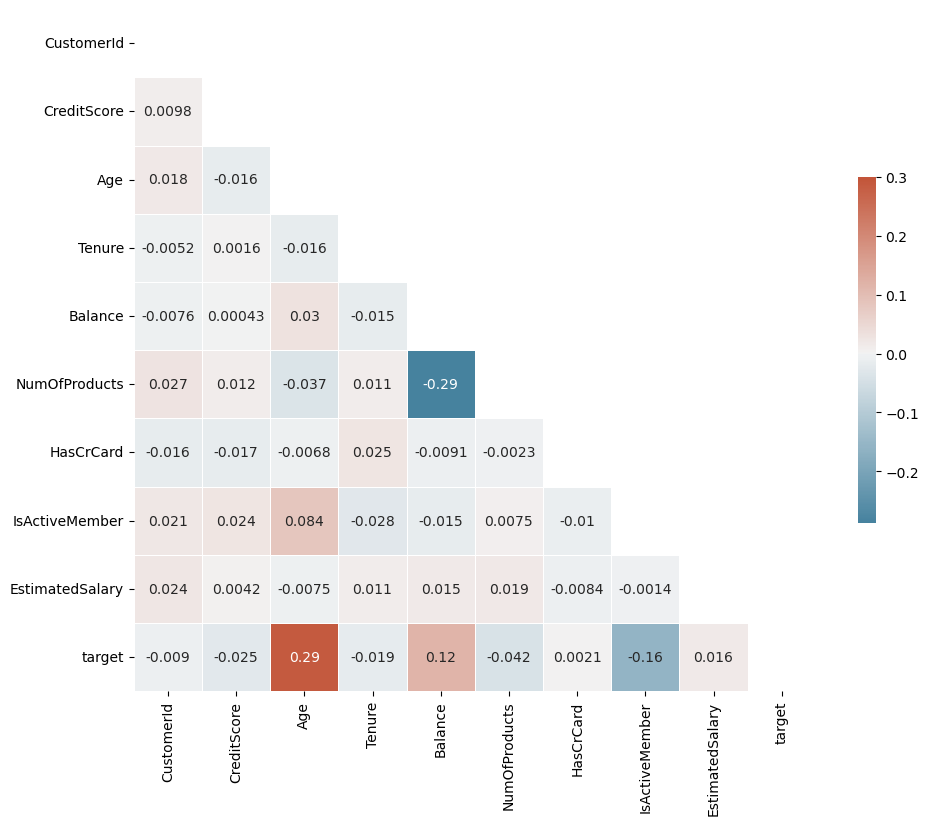

In [1112]:
# Plot correlation matrix
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

In [1113]:
# Get general numerical information.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,6000.0,1.569095e+07,72079.359562,15565706.00,15628821.25,1.569081e+07,1.575398e+07,15815660.00
CreditScore,6000.0,6.487317e+02,96.504908,350.00,582.00,6.500000e+02,7.150000e+02,850.00
Age,6000.0,3.895017e+01,10.503003,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,6000.0,5.039000e+00,2.905378,0.00,3.00,5.000000e+00,8.000000e+00,10.00
Balance,6000.0,7.728675e+04,62397.177683,0.00,0.00,9.773521e+04,1.278722e+05,250898.09
NumOfProducts,6000.0,1.530833e+00,0.582328,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,6000.0,7.091667e-01,0.454185,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,6000.0,5.161667e-01,0.499780,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,6000.0,9.995226e+04,57624.671345,11.58,50824.33,1.000941e+05,1.493882e+05,199970.74
target,6000.0,2.093333e-01,0.406867,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [1114]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

### Numerical Features vs. Target

Plot numerical features vs target to see if we can get any insights.

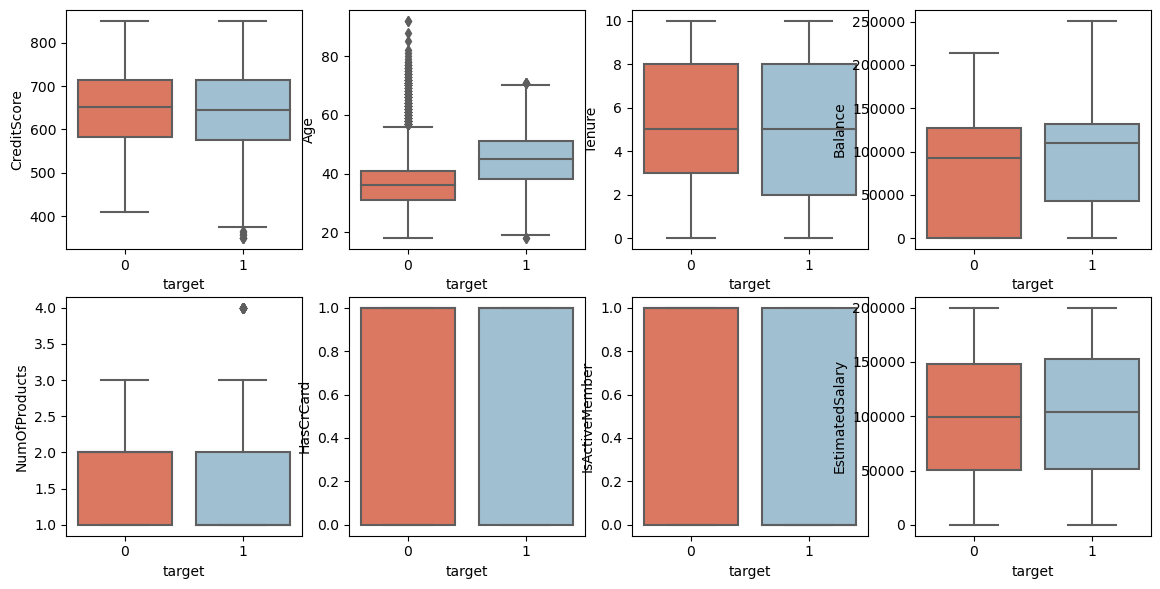

In [1115]:
# BOX PLOT

cat_list= ["CreditScore","Age","Tenure", "Balance",	"NumOfProducts","HasCrCard", "IsActiveMember","EstimatedSalary"]
fig = plt.figure(figsize =(14,18))

for i in range(len(cat_list)):
    column = cat_list[i]
    sub = fig.add_subplot(5,4,i+1)
    sns.boxplot( x = "target", y = column, data = df)

In [1116]:
# PAIR PLOT

# num_columns = ["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]

# sns.pairplot(df,
#              hue='target',
#              height=4,
#              vars=num_columns,
#              kind="reg");

## Check Outliers 👀

Even though in the future outliers may be present we prefer to fit our model without taking them into account as the model will predict better.

We must look in our dataset just in case they exist and analyze them to find out what to do with them.

From the following graphs we can see that there are 3 attributes that have noticeable outliers: 
* **Age**
* **CreditScore**
* **NumOfProducts**


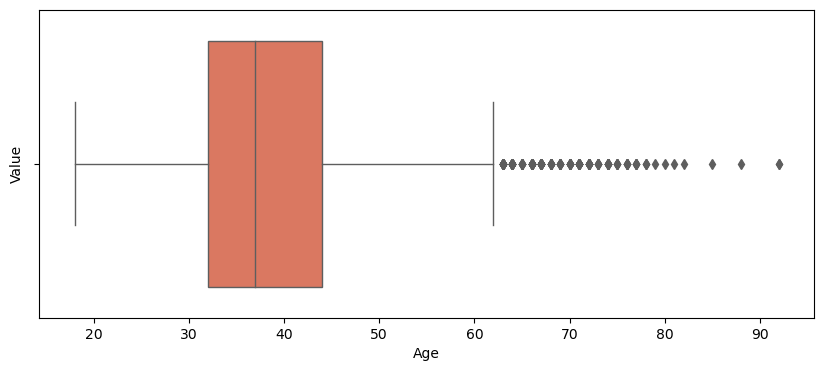

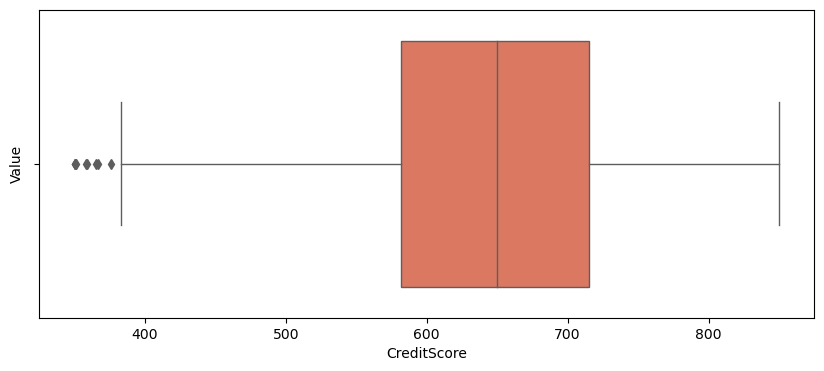

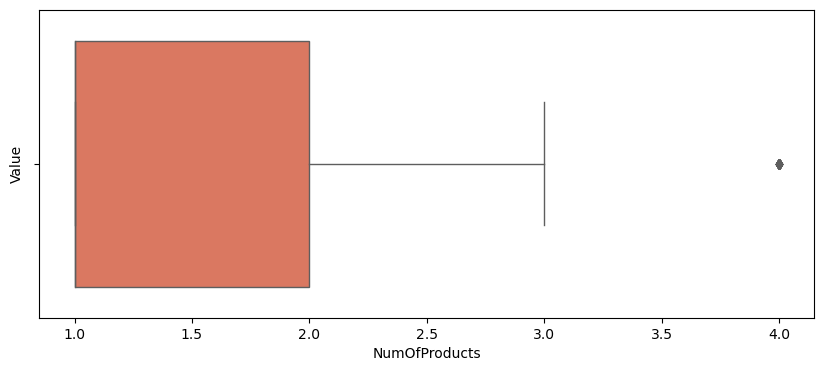

In [1117]:
# For simplicity we will only plot the 3 most noticeable. 
cat_list= ["Age", "CreditScore", "NumOfProducts"]

for i in cat_list:
    fig, ax_box = plt.subplots(figsize=(10, 4))
    sns.boxplot(df[i], ax=ax_box, linewidth=1.0, palette=colors)
    ax_box.set_xlabel(i)
    ax_box.set_ylabel('Value')
    plt.show(block=False)
    plt.pause(0.1)
    plt.close(fig)

In [1118]:
# We will remove certain outliers without removing too many samples. 
# Remember we have a sample of 6,000 rows in our train dataframe so we must be careful of removing too many rows.
len(df)

6000

### Box Plot Refresh

Although there are several ways to detect outliers we will use Tukey´s rule also known as the IQR rule.

First, we will calculate the **Interquartile Range of the data (IQR = Q3 — Q1).** Later, we will determine our outlier boundaries with IQR.

We will get our lower boundary with this calculation Q1–1.5 * IQR. We will get our upper boundary with this calculation Q3 + 1.5 * IQR.

<img src="https://www.simplypsychology.org/wp-content/uploads/boxplot-outliers.png" width=800 height=400>


### Remove `Age` Outliers

In [1119]:
Q1 = df["Age"].quantile(0.25)
Q3 = df["Age"].quantile(0.75)

IQR = Q3 - Q1

lower_lim = Q1  - 1.5 * IQR
upper_lim = Q3  + 1.5 * IQR

print("Age lower limit:",lower_lim)
print("Age upper limit:",upper_lim)


# Mask 
lower_outliers =(df["Age"]<lower_lim)
upper_outliers =(df["Age"]>upper_lim)

print("Number of outliers removed by Age:",len(df["Age"][(lower_outliers|upper_outliers)]))

df = df[~(lower_outliers|upper_outliers)]
len(df)


Age lower limit: 14.0
Age upper limit: 62.0
Number of outliers removed by Age: 218


5782

### Remove `CreditScore` Outliers

In [1120]:
Q1 = df["CreditScore"].quantile(0.25)
Q3 = df["CreditScore"].quantile(0.75)

IQR = Q3 - Q1

lower_lim = Q1  - 1.5 * IQR
upper_lim = Q3  + 1.5 * IQR

print("CreditScore lower limit:",lower_lim)
print("CreditScore upper limit:",upper_lim)


# Mask 
lower_outliers =(df["CreditScore"]<lower_lim)
upper_outliers =(df["CreditScore"]>upper_lim)

print("Number of outliers removed by CreditScore:",len(df["CreditScore"][(lower_outliers|upper_outliers)]))

df = df[~(lower_outliers|upper_outliers)]
len(df)

CreditScore lower limit: 382.5
CreditScore upper limit: 914.5
Number of outliers removed by CreditScore: 9


5773

### Remove `NumOfProducts` Outliers

In [1121]:
Q1 = df["NumOfProducts"].quantile(0.25)
Q3 = df["NumOfProducts"].quantile(0.75)

IQR = Q3 - Q1

lower_lim = Q1  - 1.5 * IQR
upper_lim = Q3  + 1.5 * IQR

print("NumOfProducts lower limit:",lower_lim)
print("NumOfProducts upper limit:",upper_lim)


# Mask 
lower_outliers =(df["NumOfProducts"]<lower_lim)
upper_outliers =(df["NumOfProducts"]>upper_lim)

print("Number of outliers removed by NumOfProducts:",len(df["NumOfProducts"][(lower_outliers|upper_outliers)]))

df = df[~(lower_outliers|upper_outliers)]
print("Outliers removed: ",6000-len(df),"out of 6,000")

NumOfProducts lower limit: -0.5
NumOfProducts upper limit: 3.5
Number of outliers removed by NumOfProducts: 33
Outliers removed:  260 out of 6,000


### Is our Data Balanced ? ⚖️

Most machine learning algorithms work best when the number of samples in each class is about equal. This is because most algorithms are designed to maximize accuracy and reduce errors.

If the dataframe has imbalanced classes you get a pretty high accuracy just by predicting the **majority class**, but you fail to capture the **minority class**, which is most often the point of creating the model in the first place. 


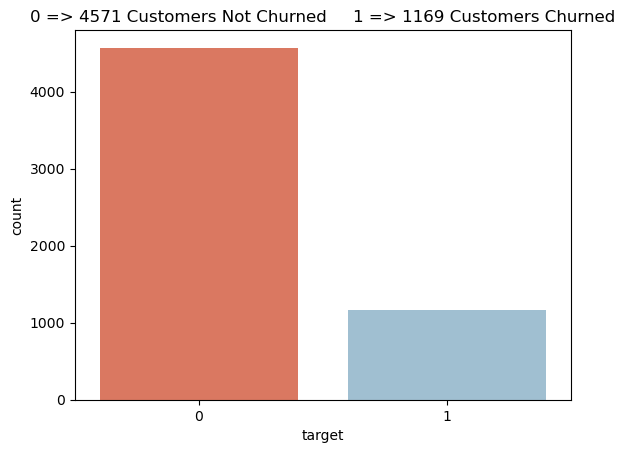

In [1122]:
# In this example we can see that there is quite a big difference.
x, y  = df["target"].value_counts()

title = "0 => "+ str(x)+ " Customers Not Churned     1 => "+str(y)+ " Customers Churned"

sns.countplot(x="target", data=df).set(title=title)
plt.show()

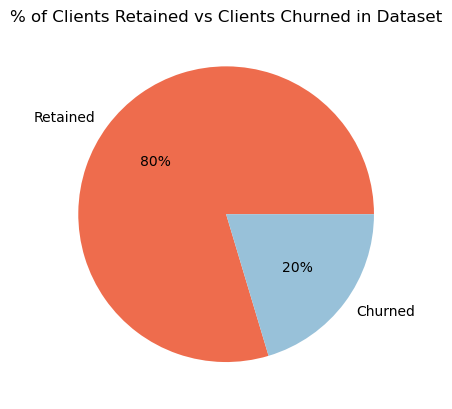

In [1123]:
# Show as %
x, y  = df["target"].value_counts()

# plotting data on chart
plt.pie([x,y], labels=["Retained","Churned"], autopct='%.0f%%')
  
# displaying chart
plt.title("% of Clients Retained vs Clients Churned in Dataset")
plt.show()

### Balance Data by Random Under-Sample

From the above graph we can see that if we didn´t bother to train a model and just create a function that tells us that the client will not leave we would be 80% accurate!

This accuracy would be **misleading** as your overall accuracy would be high simply because most of the customers will not change bank.

Since our dataset is sufficiently large ( 4,578 retained clients vs 1,146 churned clients), we will **drop retained clients** in order to later make better predictions with our machine learning models.

Remember, that the **drawback** of undersampling is that we may **remove information** that may be **valuable.** A good rule of thumb is to have at least >1,000 different clients who are retained and churned. We will actually end up with 2,292 clients (1,146 clients of each group).

In [1124]:
# Remember how our df looked.
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
3776,15652218,750,France,Male,33,2,152302.72,1,1,0,71333.44,0
330,15598493,656,France,Male,50,7,0.00,2,0,1,72143.44,0
9274,15793425,560,Spain,Female,33,9,0.00,1,0,1,183358.21,0
8105,15635116,659,Spain,Male,60,2,0.00,1,1,0,177480.45,1
1939,15799710,739,France,Male,37,7,104960.46,1,0,1,80883.82,0


In [1125]:
rus = RandomUnderSampler(random_state=42)
# X_rus, y_rus = rus.fit_resample(df.loc[:, 'CreditScore':'EstimatedSalary'], df['target'])

X_train, y_train = rus.fit_resample(df.iloc[:, 0:11], df['target'])

X_train 

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15631813,621,France,Male,39,6,0.00,2,1,1,58883.91
1,15614962,623,Spain,Female,50,2,87116.71,1,1,1,104382.11
2,15586970,695,Germany,Male,52,8,103023.26,1,1,1,22485.64
3,15672640,850,Spain,Female,45,4,114347.85,2,1,1,109089.04
4,15706764,560,France,Female,35,1,0.00,2,1,0,3701.63
...,...,...,...,...,...,...,...,...,...,...,...
2333,15778410,533,Spain,Female,52,7,0.00,1,0,1,194113.99
2334,15643024,479,Germany,Male,35,4,138718.92,1,1,1,47251.79
2335,15629323,617,Germany,Female,37,4,116471.43,2,1,0,175324.74
2336,15723299,774,France,Male,53,4,113709.28,1,1,1,153887.93


Text(0.5, 1.0, 'Random Under-Sampling')

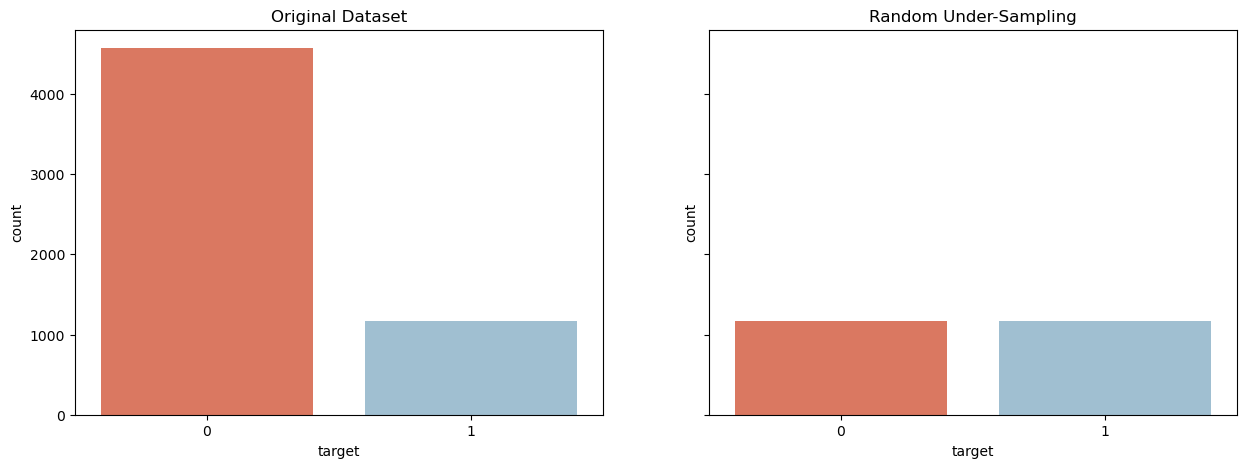

In [1126]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Original target
sns.countplot(x="target", data=df, ax=axes[0])
axes[0].set_title("Original Dataset")

# RandomUnderSampler
sns.countplot(y_train, ax=axes[1])
axes[1].set_title("Random Under-Sampling")


In [1127]:
df = pd.concat([X_train, y_train],ignore_index=False,axis=1,sort=False)
df_val = pd.concat([X_val, y_val],ignore_index=False,axis=1,sort=False)


### Feature Importance

With feature importance we can find out what feature is the most significant given a model and will have a larger effect. This will result in greater "importance"

Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

Text(0.5, 0, 'Feature Importance')

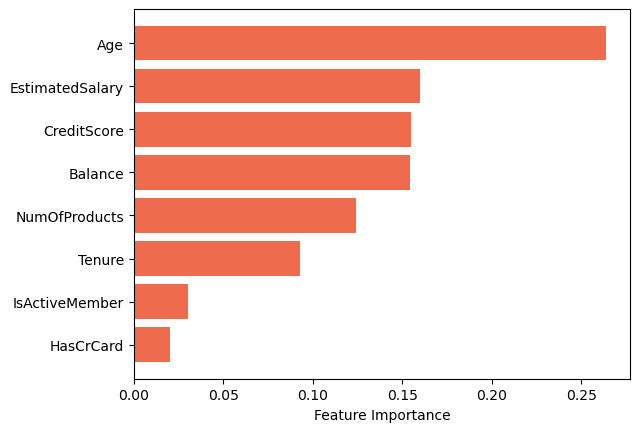

In [1128]:
X = X_train.loc[:,['CreditScore','Age',"Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]]

rf = RandomForestClassifier(n_estimators=150)
rf.fit(X, y_train)

sort = rf.feature_importances_.argsort()
plt.barh(X.columns[sort], rf.feature_importances_[sort],color='#ee6c4d')
plt.xlabel("Feature Importance")

## Encoding Categorical Features

When there are features that have no arbitrary text i.e. there is a limited number of possible values we should convert these categories from text to numbers. This is because most Machine Learning algorithms prefer to work with numbers.

 **One Hot Encoding**

We are going to encode features *Geography* and *Gender* to see if our metrics improve. We will use **logistic regression, cross validation and pipeline** to achieve this.

<!-- 
Why use pipeline (chaining steps together) ?
1. It allows you to properly cross validate a process rather than just a model
2. You can do a grid search or randomized search of both tuning parameters for the model and the preprocessing steps

* You don´t have to create a gigantic dataframe
* When new data comes in you don´t have to use get dummies
* You can do a  grid search with both model parameters and pre-processing parameters
* In some cases, preprocessing outside of scikit-learn can make cross-validation scores less reliable

-->

In [1129]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
0,15631813,621,France,Male,39,6,0.00,2,1,1,58883.91,0
1,15614962,623,Spain,Female,50,2,87116.71,1,1,1,104382.11,0
2,15586970,695,Germany,Male,52,8,103023.26,1,1,1,22485.64,0
3,15672640,850,Spain,Female,45,4,114347.85,2,1,1,109089.04,0
4,15706764,560,France,Female,35,1,0.00,2,1,0,3701.63,0


In [1130]:
# One-hot encoding for train

transformer = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),
                                    ["Geography","Gender"]),
                                    remainder='passthrough'
                                    )

transformed = transformer.fit_transform(df)

df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

df.head()                                    

,onehotencoder__Geography_France,onehotencoder__Geography_Germany,onehotencoder__Geography_Spain,onehotencoder__Gender_Female,onehotencoder__Gender_Male,remainder__CustomerId,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary,remainder__target
0,1.0,0.0,0.0,0.0,1.0,15631813.0,621.0,39.0,6.0,0.00,2.0,1.0,1.0,58883.91,0.0
1,0.0,0.0,1.0,1.0,0.0,15614962.0,623.0,50.0,2.0,87116.71,1.0,1.0,1.0,104382.11,0.0
2,0.0,1.0,0.0,0.0,1.0,15586970.0,695.0,52.0,8.0,103023.26,1.0,1.0,1.0,22485.64,0.0
3,0.0,0.0,1.0,1.0,0.0,15672640.0,850.0,45.0,4.0,114347.85,2.0,1.0,1.0,109089.04,0.0
4,1.0,0.0,0.0,1.0,0.0,15706764.0,560.0,35.0,1.0,0.00,2.0,1.0,0.0,3701.63,0.0


In [1131]:
transformer = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),
                                    ["Geography","Gender"]),
                                    remainder='passthrough'
                                    )

transformed = transformer.fit_transform(df_val)

df_val = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

df_val.head()

,onehotencoder__Geography_France,onehotencoder__Geography_Germany,onehotencoder__Geography_Spain,onehotencoder__Gender_Female,onehotencoder__Gender_Male,remainder__CustomerId,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary,remainder__target
0,1.0,0.0,0.0,1.0,0.0,15640953.0,611.0,26.0,2.0,107508.93,2.0,1.0,1.0,120801.65,0.0
1,0.0,1.0,0.0,1.0,0.0,15809178.0,569.0,42.0,9.0,146100.75,1.0,1.0,0.0,32574.01,1.0
2,0.0,1.0,0.0,1.0,0.0,15713826.0,613.0,20.0,0.0,117356.19,1.0,0.0,0.0,113557.70,1.0
3,0.0,1.0,0.0,0.0,1.0,15593280.0,614.0,43.0,8.0,140733.74,1.0,1.0,1.0,166588.76,0.0
4,0.0,0.0,1.0,0.0,1.0,15667456.0,709.0,62.0,3.0,0.00,2.0,1.0,1.0,82195.15,0.0


In [1045]:
# Divide our one hot encoded df into train and test so we can do futher testing

X_train = df.drop(['remainder__target'], axis = 1)
y_train = df['remainder__target']

X_test = df_val.drop(['remainder__target'], axis = 1)
y_test = df_val['remainder__target']

## Machine Learning Models

We will be using the following machine learning models:

1. Logistic Regression
2. Support Vector Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier
4. XGBoost
5. k-Nearest Neighbors
6. Decision Trees
7. Support Vector Machine
8. Naive Bayes


And **GridSearchCV:** to tune our hyperparameters and select the best combination of parameters for our data.

### Logistic Regression

In [1047]:
lr = LogisticRegression(random_state=42)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,1000],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring="recall",
                      cv=5, # K-fold cross-validation.
                      verbose=False,
                      n_jobs=-1)


# Fit in test
print("Test grid",grid.fit(X_train, y_train))


# X_val = ct.fit_transform(X_val)

# print("Score:",grid.score(X_val, y_val))
# print("Best Estimator:",grid.best_estimator_) # gives the best combination of tuned hyperparameters
# print("Best Score:",grid.best_score_) # gives the average cross-validated score




/Users/ignaciogarciabarrero/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ignaciogarciabarrero/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ignaciogarciabarrero/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ignaciogarciabarrero/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ignaciogarciabarrero/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/User

Test grid GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000],
                         'max_iter': [100], 'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='recall', verbose=False)


In [1048]:
X_train

,onehotencoder__Geography_France,onehotencoder__Geography_Germany,onehotencoder__Geography_Spain,onehotencoder__Gender_Female,onehotencoder__Gender_Male,remainder__CustomerId,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary
0,0.0,0.0,1.0,1.0,0.0,15592578.0,614.0,41.0,7.0,146997.64,2.0,0.0,0.0,137791.18
1,1.0,0.0,0.0,1.0,0.0,15689147.0,652.0,40.0,1.0,0.00,2.0,1.0,0.0,126554.96
2,0.0,1.0,0.0,0.0,1.0,15702669.0,663.0,44.0,2.0,117028.60,2.0,0.0,1.0,144680.18
3,1.0,0.0,0.0,1.0,0.0,15796231.0,681.0,18.0,1.0,98894.39,1.0,1.0,1.0,9596.40
4,0.0,0.0,1.0,1.0,0.0,15685245.0,608.0,56.0,5.0,0.00,2.0,0.0,1.0,153810.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,0.0,0.0,1.0,1.0,0.0,15641934.0,749.0,46.0,9.0,66582.81,1.0,1.0,0.0,78753.12
2262,0.0,1.0,0.0,0.0,1.0,15762169.0,556.0,37.0,9.0,145018.64,2.0,1.0,0.0,90928.02
2263,0.0,0.0,1.0,1.0,0.0,15731951.0,689.0,28.0,5.0,95328.60,1.0,1.0,0.0,6129.61
2264,0.0,1.0,0.0,0.0,1.0,15767264.0,465.0,53.0,1.0,117438.17,1.0,0.0,0.0,74898.80


In [813]:
X_train

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.4296329e+05],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 3.0579820e+04],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 3.7662490e+04],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 1.5661838e+05],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 8.8391290e+04],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 1.4200946e+05]])

In [848]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm

pipe = Pipeline(steps=[("classifier", RandomForestClassifier())])

# No hay pre-procesado.

#  Voy a probar varias combinaciones de hiperparametros para ver cuál me da mejor rendimiento

# Hiperparámetros de regresión logística
logistic_params = {
    'classifier': [LogisticRegression()],
    'classifier__penalty': ['l1', 'l2'], # evita overfitting
    'classifier__C': np.arange(0.1, 4, 0.5)
}

# Hiperparámetros de Random Forest
random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [10, 100, 500, 1000],
    'classifier__max_features': [1,2,3]
}

# Hiperparámetros de Support Vector Classifiaction
svc_params = {
    'classifier': [svm.SVC()],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid']
}

search_space = [logistic_params, random_forest_params, svc_params]

grid = GridSearchCV(pipe,
                   search_space, #documentación se llama param_grid
                   cv = 10,
                   n_jobs=-1)

grid.fit(X_train, y_train)

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.